<a href="https://colab.research.google.com/github/giacomogreggio/HSL-citybikes-predictor/blob/master/HSL_citybikes_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Citybike predictor

### Elevator pitch
Scheduling your day is important for everyone, but every day we have to face problems related to planning your itinerary. When you want to use a citybike to move from a place to another you may find yourself at an empty bike station. Could there be a way to predict the availability? A solution: an application that predicts exactly that based on the time and the weather.


### Data: sources, wrangling, management		
- The original purpose of the data is not compatible with our needs: the data is meant to describe bike trips/routing, not the bike availability
- 
            
### Data analysis: statistics, machine learning	
- We need a predicting model
- Predictions for time series: a lot of different variables
- Combining different data sources to base the prediction to current situation: weather, time of the day, current bike availability    


### Communication of results: summarization & visualization
- Finding clear and intuitive way to summarize and visualize data such that it is accessible to the user
- 
            
### Operationalization: creating added value, end-user point of view
- Mobile optimated web application

## Preprocessing the HSL-data

### Initializing everything

In [1]:
!pip install mpld3

     |████████████████████████████████| 1.0MB 2.8MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.1-cp36-none-any.whl size=364064 sha256=ad724393070a942af68087232dbba01a19cfef1de51c96ffc5c2685447f6466e
  Stored in directory: /root/.cache/pip/wheels/38/68/06/d119af6c3f9a2d1e123c1f72d276576b457131b3a7bf94e402
Successfully built mpld3


In [2]:
# All imports

import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import datetime
from pandas.tseries.offsets import MonthEnd
import seaborn as sns
import numpy as np
#import mpld3
#from mpld3 import plugins
#mpld3.enable_notebook()

In [3]:
drive.mount('/content/drive')


Mounted at /content/drive


### Data preprocessing functions

In [4]:
def get_station_data():
  stations = pd.read_csv("/content/drive/My Drive/HSLDataset/Helsingin_ja_Espoon_kaupunkipyöräasemat.csv")
  stations = stations.drop(["FID", "Nimi", "Namn", "Adress", "Kaupunki", "Stad", "Operaattor"], axis = 1)
  return stations

In [5]:
def rate_weather(row):
    score = 10
    if row['cloud_amount']<2 : score = score
    if row['cloud_amount']<5 and row['cloud_amount']>=2 : score = score-1
    if row['cloud_amount']<8 and row['cloud_amount']>=5 : score = score-2
    if row['cloud_amount']>=8 : score = score-3
    if row['visibility']>=40000 : score = score
    if row['visibility']>=10000 and row['visibility']<40000 :  score = score-1
    if row['visibility']<10000 :  score = score-2
    if row['rain_intensity']<=0.25 :  score = score
    if row['rain_intensity']<=1 and row['rain_intensity']>0.25: score = score-1   
    if row['rain_intensity']<=4 and row['rain_intensity']>1: score = score-2
    if row['rain_intensity']<=16 and row['rain_intensity']>4: score = score-3
    if row['rain_intensity']>16: score = score-4   
    if row['wind_speed']<=1.5: score = score   
    if row['wind_speed']<=3.3 and row['wind_speed']>1.5: score = score-1
    if row['wind_speed']<=8 and row['wind_speed']>3.3: score = score-2
    if row['wind_speed']>8: score = score-3
    if score<1 : score = 1
    return(score)

In [6]:
def get_weather_data():
  filepath ='/content/drive/My Drive/HSLDataset/bikeweather_2019.csv'
  df = pd.read_csv(filepath)
  df = df.rename(
      columns={
      'Vuosi': 'year', 'Kk': 'month', 'Pv': 'day', 'Klo': 'time', 'Aikavyöhyke': 'timezone', 'Pilvien määrä (1/8)': 'cloud_amount',
      'Ilmanpaine (msl) (hPa)': 'pressure', 'Suhteellinen kosteus (%)': 'rel_humidity', 'Sateen intensiteetti (mm/h)': 'rain_intensity',
      'Lumensyvyys (cm)': 'snow_depth', 'Ilman lämpötila (degC)': 'air_temp', 'Kastepistelämpötila (degC)': 'dew-point_temp',
      'Näkyvyys (m)': 'visibility', 'Tuulen suunta (deg)': 'wind_dir', 'Puuskanopeus (m/s)': 'gust_speed', 'Tuulen nopeus (m/s)': 'wind_speed'
      }
  )
  df = df.drop(['pressure', 'rel_humidity', 'snow_depth', 'dew-point_temp', 'wind_dir', 'gust_speed'], axis=1)
  df['datetime']=pd.to_datetime(df.year.astype(str)+'-'+df.month.astype(str)+'-'+df.day.astype(str)+' '+df.time.astype(str))
  df['weather_rate'] = df.apply(lambda row: rate_weather(row), axis=1)
  return df  

In [7]:
def preprocess_month(month):
  path = "/content/drive/My Drive/HSLDataset/od-trips-2019/"
  extension = ".csv"
  filename = "2019-" + '{:02.0f}'.format(month)
  full_path = path + filename + extension
  
  data = pd.read_csv(full_path, sep = ",")

  # Make time a datetime object to ease handling. Also floor to starting hour
  data["Dep date"] = pd.to_datetime(data["Departure"], errors = "ignore").dt.floor(freq = "H")
  data["Return date"] = pd.to_datetime(data["Return"], errors = "ignore").dt.floor(freq = "H")

  # For our analysis we shouldn't need this information
  data = data.drop(columns=["Covered distance (m)", "Duration (sec.)", "Departure", "Return"])

  # Get the outgoing bikes per station at timeframe
  outgoing = data.groupby("Departure station id")["Dep date"].value_counts()
  outgoing = outgoing.sort_index()
  outgoing = outgoing.rename_axis(index = {"Dep date" : "Date", "Departure station id" : "ID"})
  outgoing = outgoing.rename("Outgoing")

  # Get the arriving bikes per station at timeframe
  arriving = data.groupby("Return station id")["Return date"].value_counts()
  arriving = arriving.sort_index()
  arriving = arriving.rename_axis(index = {"Return date" : "Date", "Return station id" : "ID"})
  arriving = arriving.rename("Arriving")

  outgoing_arriving_merge = pd.merge(outgoing, arriving, on = ["ID", "Date"], how = "outer")
  outgoing_arriving_merge = outgoing_arriving_merge.fillna(0)

  
  stations = set(outgoing_arriving_merge.index.get_level_values(0))

  # We need data for ALL timeframes
  first_day_of_month = "2019-" + '{:02.0f}'.format(month) + "-01 00:00:00"
  last_day_of_month = pd.Timestamp("2019-" + '{:02.0f}'.format(month) + "-01 23:00:00") + MonthEnd(0)
  all_dates = pd.date_range(first_day_of_month, last_day_of_month, freq = "H")
  idx = pd.MultiIndex.from_product([stations, all_dates], names = ["ID", "Date"])
  mega_frame_with_station_date_cartesian_product = pd.DataFrame(index = idx)
  processed = pd.merge(mega_frame_with_station_date_cartesian_product, outgoing_arriving_merge, on = ["ID", "Date"], how = "left")
  processed = processed.fillna(0)
  processed = processed.reset_index()

  # Merge with the station data from HSL
  station_data = get_station_data()
  processed_with_station_data = pd.merge(processed, station_data, on = "ID", how = "inner")

  processed_with_station_data.to_csv("./drive/My Drive/HSLDataset/processed/" + filename + "-processed.csv")

In [8]:
def process_and_write_raw_data():
  # Process all the data and save them as csv-files
  for month in range(4,11):
    data = preprocess_month(month)

#### Merging functions

In [9]:
def drop_columns_weather(df):
  return df.drop(columns=['year','month','day','time','timezone','cloud_amount','rain_intensity','air_temp','visibility','wind_speed'])

In [10]:
def drop_columns_bikes(df):
  bikes = df.drop(columns=['Osoite','Kapasiteet','x','y'])
  bikes = bikes.rename(columns={'Date':'datetime', 'Outgoing':'departures', 'Arriving':'arrivals','ID':'station_id','Name':'station_name'})
  return bikes

In [11]:
# Merging on datetime column: the column must be named 'datetime' in both tables
def merge_tables(df1, df2):
  merged = df1.merge(
    df2,
    how='inner',
    on='datetime'
  )
  return merged

#### Getters for data

In [12]:
def get_processed_data_for_month(month):
  month = '{:02.0f}'.format(month)
  data = pd.read_csv("/content/drive/My Drive/HSLDataset/processed/2019-" + month + "-processed.csv")
  data["Date"] = pd.to_datetime(data["Date"])
  
  # Don't know what this is all about but I guess everything is fine-ish :DDD
  data = data.drop("Unnamed: 0", axis = 1)

  data["weekday"] = data["Date"].dt.weekday
  return data

In [13]:
def merge_all_data_and_write():
  # Get the already processed data for all the months
  data_april = get_processed_data_for_month(4)
  data_may = get_processed_data_for_month(5)
  data_june = get_processed_data_for_month(6)
  data_july = get_processed_data_for_month(7)
  data_august = get_processed_data_for_month(8)
  data_september = get_processed_data_for_month(9)
  data_october = get_processed_data_for_month(10)

  # Concatanate the trip count data of the months
  big_boi = pd.concat([data_april, data_may, data_june, data_july, data_august, data_september, data_october])

  # Merge the weather data
  weather_data = get_weather_data()
  merged_megaset = merge_tables(drop_columns_bikes(big_boi),drop_columns_weather(weather_data))

  merged_megaset.to_csv("./drive/My Drive/HSLDataset/processed/whole_data-processed.csv", index = False)
  return merged_megaset

In [14]:
def get_all_data():
  data = pd.read_csv("./drive/My Drive/HSLDataset/processed/whole_data-processed.csv")
  data["datetime"] =pd.to_datetime(data["datetime"])
  return data

## Looking at the data

### Getter functions for specific subsets of data

In [15]:
def data_of_station_for_weekdays_in_month(dataframe, station, month, weekday):
  station_data = dataframe[dataframe["station_id"] == station]
  station_data_for_month = station_data[(station_data["datetime"].dt.month == month) & (station_data["datetime"].dt.weekday == weekday)]
  return station_data_for_month

### Test area

In [16]:
all_data = get_all_data()

In [17]:
# Useful for picking a station by name: some hot stations are most of the ones at a metro station (M) and ones near the central railway
stations = get_station_data()

## Different data visualizations

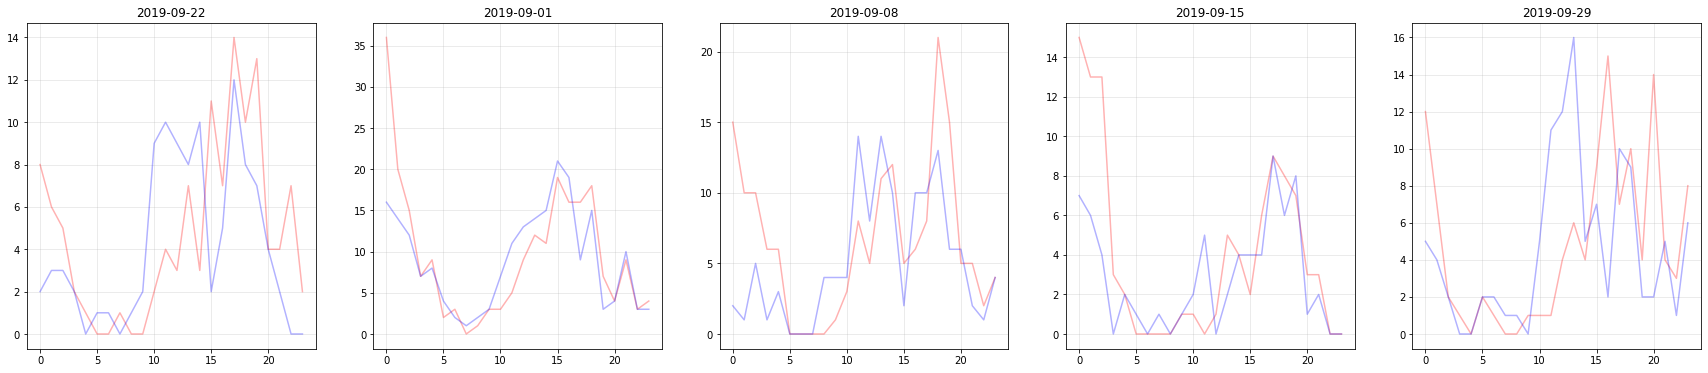

In [18]:
wanted_data = data_of_station_for_weekdays_in_month(all_data, 19, 9, 6)
weekday_occurences = set(wanted_data["datetime"].dt.date)
fig, axs = plt.subplots(1, len(weekday_occurences), figsize = (30,6))


for idx,weekday_occurence in enumerate(weekday_occurences):
  weekday_occurence_data = wanted_data[wanted_data["datetime"].dt.date == weekday_occurence]
  axs[idx].grid(True, alpha = 0.3)
  axs[idx].plot(weekday_occurence_data["datetime"].dt.hour, weekday_occurence_data["departures"], 'r', weekday_occurence_data["datetime"].dt.hour, weekday_occurence_data["arrivals"], 'b', alpha = 0.3)
  axs[idx].title.set_text(weekday_occurence)
plt.show()

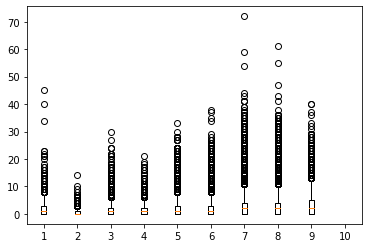

In [19]:
subset = all_data[(all_data["datetime"].dt.hour == 14)]

for rating in range(1,11):
  rating_subset = subset[subset["weather_rate"] == rating]
  plt.boxplot(rating_subset["departures"], positions=[rating])
plt.show()

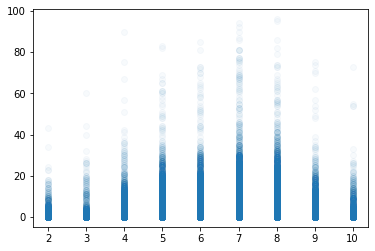

In [20]:
subset = all_data[(all_data["datetime"].dt.hour == 8)]
plt.scatter(subset["weather_rate"], subset["departures"], alpha = 0.03)

## Data analysis and visualizations

Start by printing the data as a DataFrame for a better visualization.

In [21]:
data = pd.DataFrame(get_all_data())
print(data.shape)
data

(1772712, 7)


,station_id,datetime,departures,arrivals,station_name,weekday,weather_rate
0,1,2019-04-01 00:00:00,0.0,0.0,Kaivopuisto,0,8
1,2,2019-04-01 00:00:00,0.0,0.0,Laivasillankatu,0,8
2,3,2019-04-01 00:00:00,0.0,0.0,Kapteeninpuistikko,0,8
3,4,2019-04-01 00:00:00,0.0,0.0,Viiskulma,0,8
4,5,2019-04-01 00:00:00,0.0,0.0,Sepänkatu,0,8
...,...,...,...,...,...,...,...
1772707,763,2019-10-31 23:00:00,0.0,0.0,Kalkkipellonmäki,3,9
1772708,767,2019-10-31 23:00:00,0.0,0.0,Ruutikatu,3,9
1772709,769,2019-10-31 23:00:00,0.0,0.0,Tiurintie,3,9
1772710,900,2019-10-31 23:00:00,0.0,0.0,Orionintie,3,9


Print for each feature the corresponding histogram to see the distribution of the data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2c03ff518>,
      dtype=object)

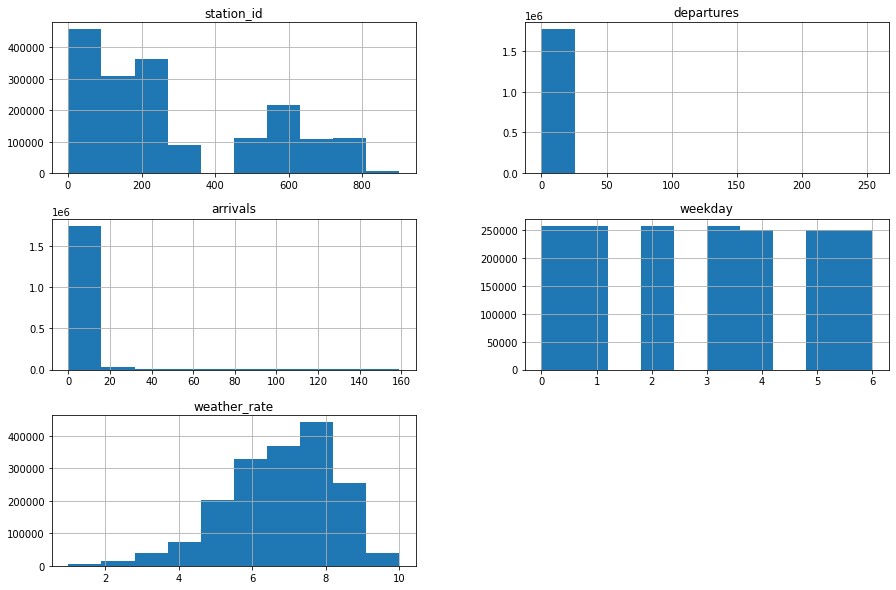

In [22]:
data.hist(figsize=(15,10))

A good way to check the correlations among columns is by visualizing the correlation matrix as heatmap.

As we can see below the darker colors means that there is a strong correlation between the two variables, instead of the lighter colors that means that there is a weak correlation.

In our case we notice that the departures and the arrivals are stictly correlated and also these last two features have a correlation with the weather_rate.

On the other hand seems that station_id has a weak correlation with departures and arrivals.

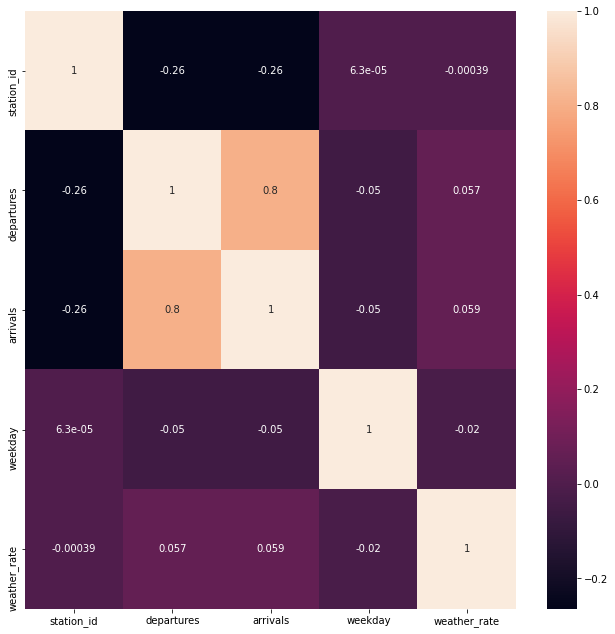

In [23]:
fig, ax = plt.subplots(figsize=(11,11))
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True, ax=ax)
plt.show()

### General behaviour

To analyzing the data we have to work on a subset of the entire dataset. For the first visualization of the general pattern related to the departures we chose the data of October 2019.
We have 24 hours per day so we decided to reduce the data for the analysis to the data related to Monday (working day).

In [24]:
# get data of all mondays of last year
monday_indexes = np.where(data['weekday'] == 0)
monday_data = data.loc[monday_indexes]
print(monday_data.shape)
monday_data.head()

(256752, 7)


,station_id,datetime,departures,arrivals,station_name,weekday,weather_rate
0,1,2019-04-01,0.0,0.0,Kaivopuisto,0,8
1,2,2019-04-01,0.0,0.0,Laivasillankatu,0,8
2,3,2019-04-01,0.0,0.0,Kapteeninpuistikko,0,8
3,4,2019-04-01,0.0,0.0,Viiskulma,0,8
4,5,2019-04-01,0.0,0.0,Sepänkatu,0,8


In [25]:
# get the data of all mondays in October 2019
october_data_m = []
for i in monday_data['datetime']:
    if i.month == 10:
        october_data_m.append(i)
    else:
        october_data_m.append(0)
october_data_m = pd.DataFrame(np.array(october_data_m), columns=['monday_datetime'])
october_data_m

,monday_datetime
0,0
1,0
2,0
3,0
4,0
...,...
256747,2019-10-28 23:00:00
256748,2019-10-28 23:00:00
256749,2019-10-28 23:00:00
256750,2019-10-28 23:00:00


In [26]:
departures_all = np.where(october_data_m['monday_datetime']!=0,monday_data['departures'],-1)
station_all = np.where(october_data_m['monday_datetime']!=0,monday_data['station_id'],-1)
weather_all = np.where(october_data_m['monday_datetime']!=0,monday_data['weather_rate'],-1)
# get the departures on monday in October
departures_monday = []
for i in departures_all:
    if i != -1:
        departures_monday.append(i)
print(max(departures_monday))
departures_monday = np.array(departures_monday)
print(departures_monday.shape)

# clean the monday data by removing zero values that are previously added
datetime_monday = []
for i in october_data_m['monday_datetime']:
    if i != 0:
        datetime_monday.append(i)
datetime_monday = np.array(datetime_monday)
datetime_monday.shape

# get the station_id that have departures on monday in October
station_monday = []
for i in station_all:
    if i != -1:
        station_monday.append(i)
station_monday = np.array(station_monday)
print(station_monday.shape)

# get the weather on monday in October
weather_monday = []
for i in weather_all:
    if i != -1:
        weather_monday.append(i)
weather_monday = np.array(weather_monday)
print(weather_monday.shape)

57.0
(33408,)
(33408,)
(33408,)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'October (monday) departures from all the stations')

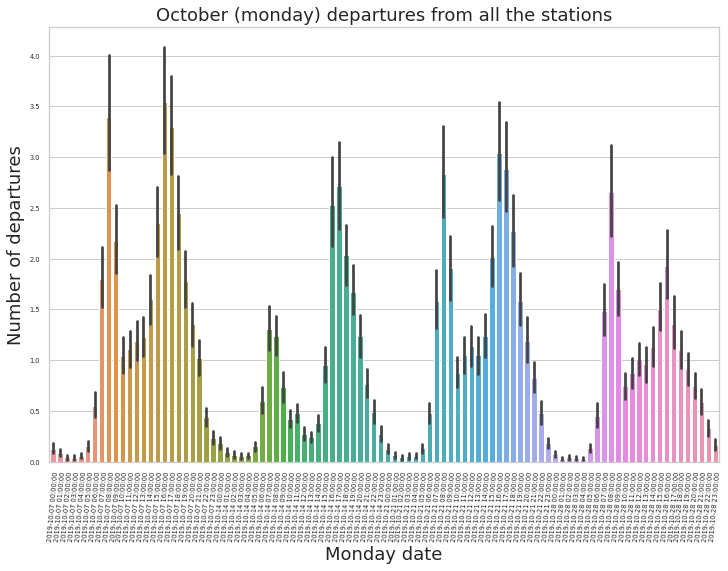

In [27]:
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=0.6)
sns.barplot(datetime_monday,departures_monday)
plt.xlabel("Monday date", fontsize=18)
plt.xticks(rotation=85)
plt.ylabel("Number of departures", fontsize=18)
plt.title("October (monday) departures from all the stations",fontsize=18)

### Data visualization for popular non-popular station

Now we want to display the data related to one of the most popular stations and the data associated with one of these that is non-popular.

Start by looking for a popular station: in this case we searched through the sum of departures and arrivals in the whole year per station and we found out the most popular station and the less popular station that are shown below.

In [28]:
total_departures_per_station = {}
total_arrivals_per_station = {}
i=0
for j in data['station_name']:
    if total_departures_per_station.get(j):
        total_departures_per_station[j] = total_departures_per_station.get(j) + data['departures'][i]
    else:
        total_departures_per_station[j] = data['departures'][i]
    if total_arrivals_per_station.get(j):
        total_arrivals_per_station[j] = total_arrivals_per_station.get(j) + data['arrivals'][i]
    else:
        total_arrivals_per_station[j] = data['arrivals'][i]
    i +=1

# convert dict into numpy array
total_departures_per_station = list(total_departures_per_station.items())
total_departures_per_station = np.array(total_departures_per_station)
print(total_departures_per_station.shape)


total_arrivals_per_station = list(total_arrivals_per_station.items())
total_arrivals_per_station = np.array(total_arrivals_per_station)
print(total_arrivals_per_station.shape)

total_dep_arr_per_station = {}
for i in range(len(total_arrivals_per_station)):
    if total_departures_per_station[i][0] == total_arrivals_per_station[i][0]:
        total_dep_arr_per_station[total_departures_per_station[i][0]] = int(float(total_departures_per_station[i][1])) + int(float(total_arrivals_per_station[i][1]))

total_dep_arr_per_station


(348, 2)
(348, 2)


{'A.I. Virtasen aukio': 10346,
 'Aalto University (M), Korkeakoulua': 82515,
 'Aalto University (M), Tietotie': 24013,
 'Abraham Wetterin tie': 11996,
 'Agnetankuja': 13351,
 'Agronominkatu': 6651,
 'Ahertajantie': 7534,
 'Alakiventie': 3713,
 'Albertinkatu': 36983,
 'Annankatu': 43427,
 'Apollonkatu': 59482,
 'Arabia Shopping Center': 66746,
 'Arabiankatu': 34387,
 'Arielinkatu': 16984,
 'Armas Launiksen katu': 2885,
 'Asentajanpuisto': 6479,
 'Aulangontie': 4815,
 'Auringonkatu': 6206,
 'Avaruuskatu': 5056,
 'Baana': 59414,
 'Betonimies': 6283,
 'Brahen kenttä': 46139,
 'Brahen puistikko': 37245,
 'Cable Factory': 53709,
 'Central Railway Station/East': 91758,
 'Central Railway Station/West': 94897,
 'Cygnaeuksenkatu': 22737,
 'Design Museum': 27234,
 'Diakoniapuisto': 31479,
 'Eerikinkatu': 22972,
 'Ehrenströmintie': 21266,
 'Elfvik': 1882,
 'Elimäenkatu': 25840,
 'Eränkävijäntori': 8750,
 'Esterinportti': 39349,
 'Eteläesplanadi': 63765,
 'Eteläinen Hesperiankatu': 29714,
 'Etuniem

In [29]:
total_dep_arr_per_station = list(total_dep_arr_per_station.items())

In [30]:
total_dep_arr_per_station = sorted(total_dep_arr_per_station, key=lambda x: x[1], reverse=True)
print(total_dep_arr_per_station[0])
print(total_dep_arr_per_station[-1])
popular_s = total_dep_arr_per_station[0][0]
non_popular_s = total_dep_arr_per_station[-1][0]

('Töölönlahdenkatu', 168977)
('Itäkeskus Metrovarikko', 563)


In [31]:
# create two dataframe: one for popular station data and one for non popular station data
pop_data = []
non_pop_data = []
for j in range(len(data)):
    if data['station_name'][j] == popular_s:
        pop_data.append(data.iloc[j])
    elif data['station_name'][j] == non_popular_s:
        non_pop_data.append(data.iloc[j])
pop_data = np.array(pop_data)
pop_data = pd.DataFrame(pop_data, columns=data.columns)
print(pop_data.shape)
non_pop_data = np.array(non_pop_data)
non_pop_data = pd.DataFrame(non_pop_data, columns=data.columns)
print(non_pop_data.shape)
non_pop_data

(5136, 7)
(2208, 7)


,station_id,datetime,departures,arrivals,station_name,weekday,weather_rate
0,291,2019-08-01 00:00:00,0,0,Itäkeskus Metrovarikko,3,7
1,291,2019-08-01 01:00:00,0,0,Itäkeskus Metrovarikko,3,7
2,291,2019-08-01 02:00:00,0,0,Itäkeskus Metrovarikko,3,5
3,291,2019-08-01 03:00:00,0,0,Itäkeskus Metrovarikko,3,6
4,291,2019-08-01 04:00:00,0,0,Itäkeskus Metrovarikko,3,6
...,...,...,...,...,...,...,...
2203,291,2019-10-31 19:00:00,2,0,Itäkeskus Metrovarikko,3,6
2204,291,2019-10-31 20:00:00,0,0,Itäkeskus Metrovarikko,3,8
2205,291,2019-10-31 21:00:00,0,0,Itäkeskus Metrovarikko,3,8
2206,291,2019-10-31 22:00:00,0,0,Itäkeskus Metrovarikko,3,8


We proceed by grouping the data based on hours of the 'datetime' because we are aiming at the sum of departures and arrivals per hour. 

In [32]:
hours = []
date = []
for i in pop_data['datetime']:
    hours.append(i.time())
hours = np.array(hours)
pop_data['hours'] = hours
pop_data_grouped_per_hour = pop_data.groupby('hours', as_index=False).sum()
print(pop_data_grouped_per_hour.shape)
pop_data_grouped_per_hour.drop(columns=['station_id', 'station_name','weekday','weather_rate'], inplace=True)
pop_data_grouped_per_hour

(24, 7)


,hours,departures,arrivals
0,00:00:00,620.0,361.0
1,01:00:00,452.0,236.0
2,02:00:00,317.0,155.0
3,03:00:00,231.0,116.0
4,04:00:00,289.0,372.0
5,05:00:00,316.0,650.0
6,06:00:00,1781.0,1805.0
7,07:00:00,5063.0,4864.0
8,08:00:00,7763.0,7988.0
9,09:00:00,4478.0,4939.0


We provided data visualization for the most popular station.

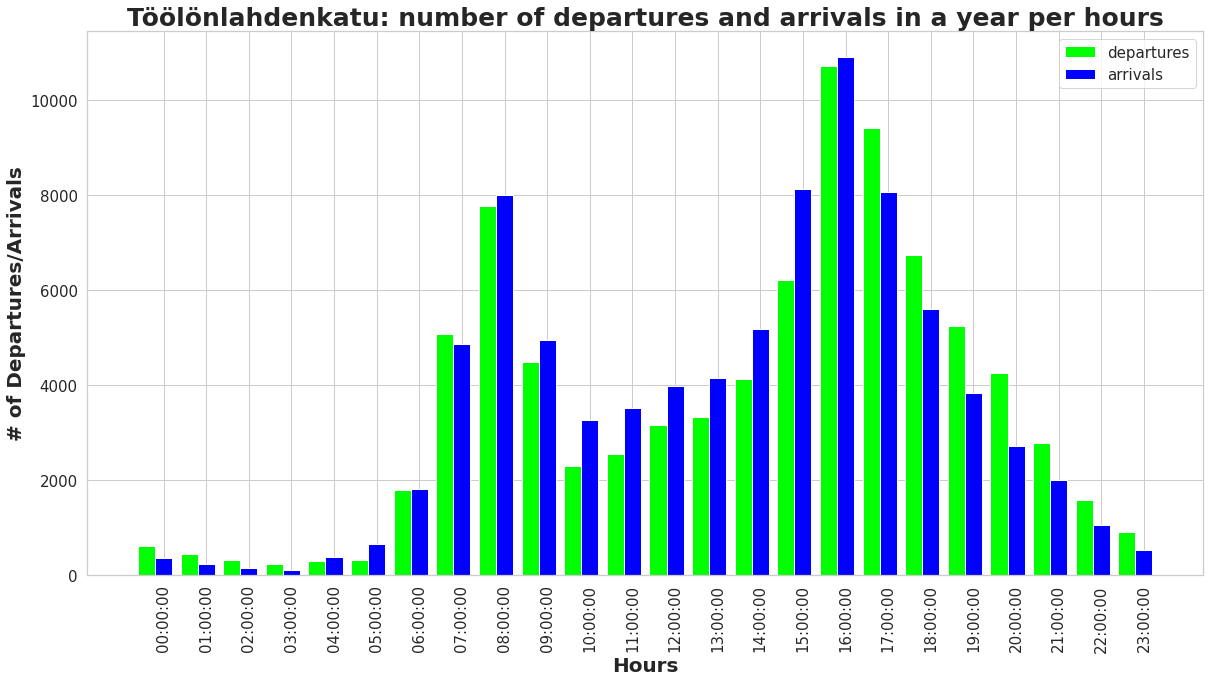

In [45]:
fig= plt.figure(figsize=(20,10))
# set width of bar
barWidth = 0.40

bars1 = pop_data_grouped_per_hour['departures']
bars2 = pop_data_grouped_per_hour['arrivals']
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='lime', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='var2')

# Add xticks on the middle of the group bars
plt.xlabel('Hours', fontweight='bold', fontsize=20)
plt.ylabel('# of Departures/Arrivals', fontweight='bold', fontsize=20)
plt.title(r'{}: number of departures and arrivals in a year per hours'.format(popular_s), fontsize=25, fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], pop_data_grouped_per_hour['hours'], fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(labels=('departures', 'arrivals'), prop={'size': 15})

We provided data visualization for the less popular station.

In [34]:
# follow same process for non popular station
hours = []
date = []
for i in non_pop_data['datetime']:
    hours.append(i.time())
hours = np.array(hours)
non_pop_data['hours'] = hours
non_pop_data_grouped_per_hour = non_pop_data.groupby('hours', as_index=False).sum()
print(non_pop_data_grouped_per_hour.shape)
non_pop_data_grouped_per_hour.drop(columns=['station_id', 'station_name','weekday','weather_rate'], inplace=True)
non_pop_data_grouped_per_hour

(24, 7)


,hours,departures,arrivals
0,00:00:00,6.0,0.0
1,01:00:00,0.0,0.0
2,02:00:00,0.0,0.0
3,03:00:00,1.0,7.0
4,04:00:00,0.0,6.0
5,05:00:00,2.0,13.0
6,06:00:00,2.0,11.0
7,07:00:00,1.0,11.0
8,08:00:00,2.0,17.0
9,09:00:00,16.0,21.0


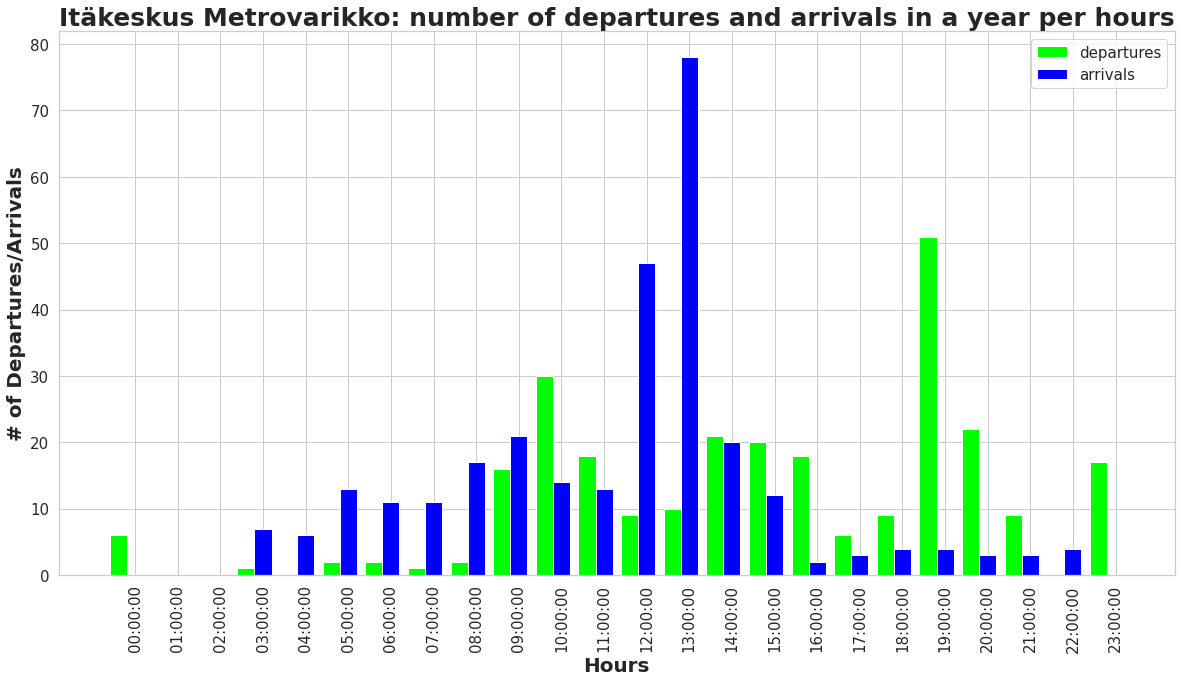

In [44]:
fig= plt.figure(figsize=(20,10))
# set width of bar
barWidth = 0.40

bars1 = non_pop_data_grouped_per_hour['departures']
bars2 = non_pop_data_grouped_per_hour['arrivals']
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='lime', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='var2')

# Add xticks on the middle of the group bars
plt.xlabel('Hours', fontweight='bold', fontsize=20)
plt.ylabel('# of Departures/Arrivals', fontweight='bold', fontsize=20)
plt.title(r'{}: number of departures and arrivals in a year per hours'.format(non_popular_s), fontsize=25, fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], non_pop_data_grouped_per_hour['hours'], fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(labels=('departures', 'arrivals'), prop={'size': 15})

### Average number of departures and arrivals

The last type of graph provided in this notebook is the average number of departures and arrivals based on: weather, hour, month, and weekday. Below you can find all the graphs. 

In [36]:
# get mean departures and arrivals based on weather in the whole year
grouped_by_weather = data.groupby('weather_rate', as_index=False).mean()
grouped_by_weather

,weather_rate,station_id,departures,arrivals,weekday
0,1,292.159993,1.718365,1.690995,3.825646
1,2,291.762258,1.279105,1.314999,3.737805
2,3,291.794520,1.115268,1.126288,3.365892
3,4,291.614539,1.391075,1.394095,3.325436
4,5,291.623881,1.694174,1.690539,2.921187
5,6,291.639144,2.072508,2.070099,2.875187
6,7,291.659905,2.344220,2.330397,2.816063
7,8,291.544028,2.553497,2.542047,3.000856
8,9,291.423259,2.035233,2.066282,3.115630
9,10,291.036120,1.809555,1.850181,2.777917


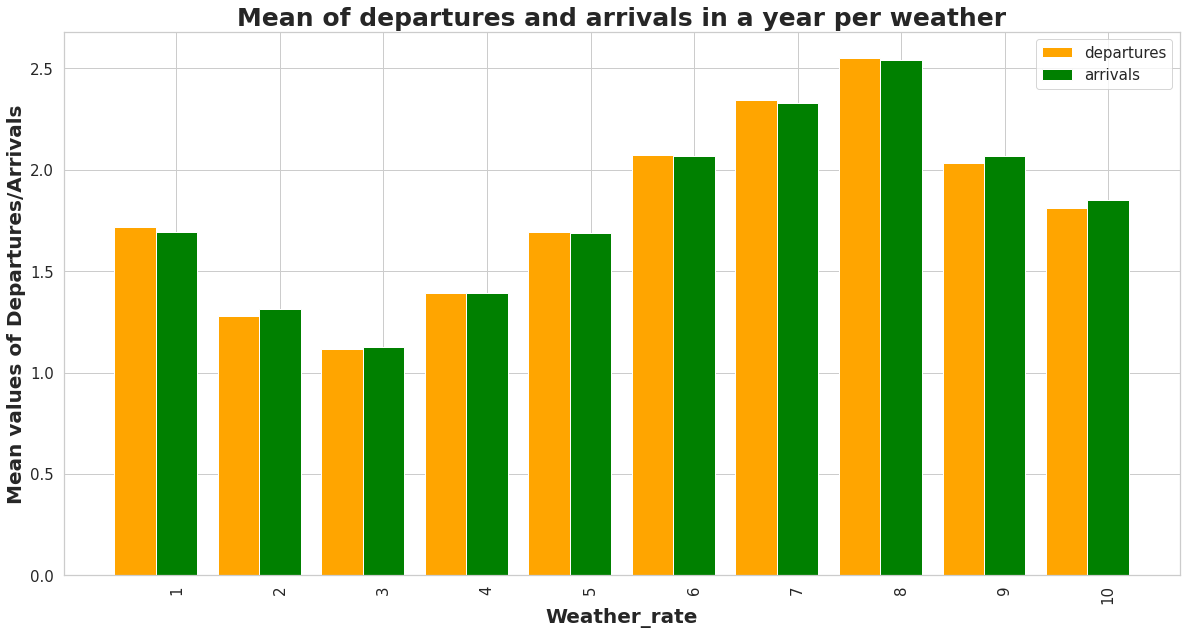

In [37]:
fig= plt.figure(figsize=(20,10))
# set width of bar
barWidth = 0.40

bars1 = grouped_by_weather['departures']
bars2 = grouped_by_weather['arrivals']
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='orange', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='green', width=barWidth, edgecolor='white', label='var2')

# Add xticks on the middle of the group bars
plt.xlabel('Weather_rate', fontweight='bold', fontsize=20)
plt.ylabel('Mean values of Departures/Arrivals', fontweight='bold', fontsize=20)
plt.title(r'Mean of departures and arrivals in a year per weather', fontsize=25, fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], grouped_by_weather['weather_rate'], fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(labels=('departures', 'arrivals'), prop={'size': 15})

In [38]:
# get mean departures and arrivals based on hours in the whole year
hours_in_data = []
for i in data['datetime']:
    hours_in_data.append(i.time())
hours_in_data = np.array(hours_in_data)
data['hours'] = hours_in_data
grouped_by_hours = data.groupby('hours', as_index=False).mean()
grouped_by_hours

,hours,station_id,departures,arrivals,weekday,weather_rate
0,00:00:00,291.578503,0.719169,0.772051,2.972341,7.181430
1,01:00:00,291.578503,0.481053,0.517851,2.972341,7.090857
2,02:00:00,291.578503,0.354900,0.384658,2.972341,7.058636
3,03:00:00,291.578503,0.237061,0.256204,2.972341,6.997577
4,04:00:00,291.578503,0.202280,0.209577,2.972341,7.043743
5,05:00:00,291.578503,0.261322,0.251763,2.972341,6.969714
6,06:00:00,291.578503,0.786713,0.665557,2.972341,6.843386
7,07:00:00,291.578503,2.155057,1.834315,2.972341,6.881158
8,08:00:00,291.578503,3.412372,3.366503,2.972341,6.694326
9,09:00:00,291.578503,2.298999,2.489000,2.972341,6.577339


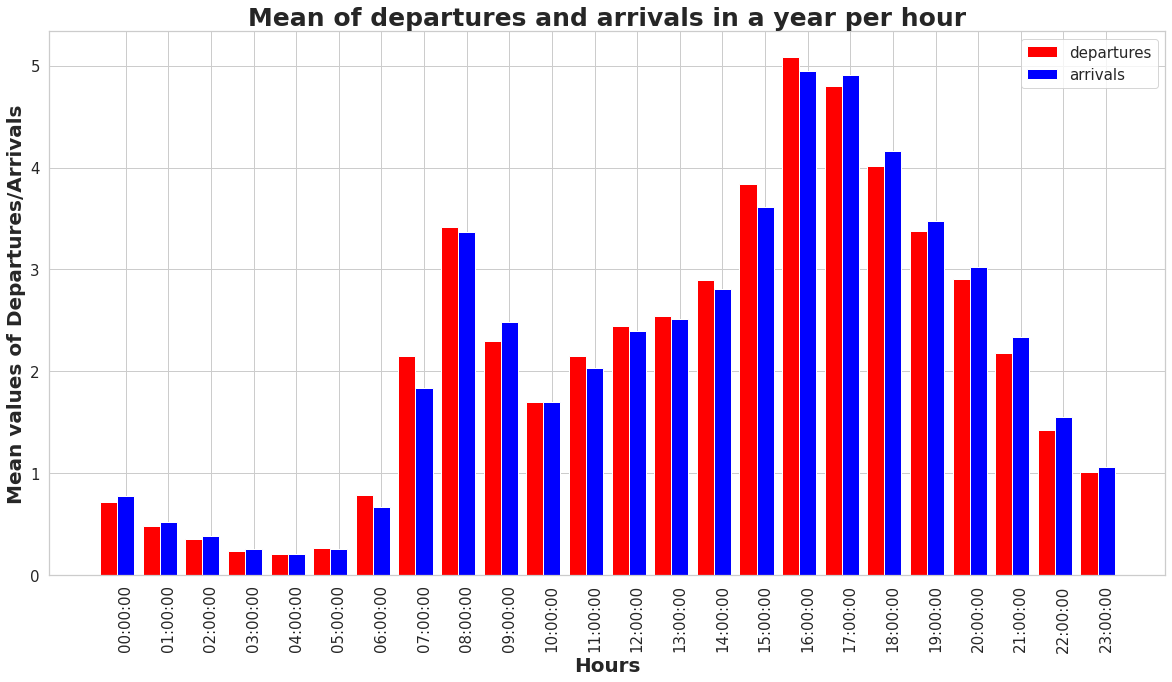

In [39]:
fig= plt.figure(figsize=(20,10))
# set width of bar
barWidth = 0.40

bars1 = grouped_by_hours['departures']
bars2 = grouped_by_hours['arrivals']
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='var2')

# Add xticks on the middle of the group bars
plt.xlabel('Hours', fontweight='bold', fontsize=20)
plt.ylabel('Mean values of Departures/Arrivals', fontweight='bold', fontsize=20)
plt.title(r'Mean of departures and arrivals in a year per hour', fontsize=25, fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], grouped_by_hours['hours'], fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(labels=('departures', 'arrivals'), prop={'size': 15})

In [40]:
# get mean departures and arrivals based on month in the whole year
month_in_data = []
for i in data['datetime']:
    month_in_data.append(i.month)
month_in_data = np.array(month_in_data)
data['month'] = month_in_data
grouped_by_month = data.groupby('month', as_index=False).mean()
grouped_by_month

,month,station_id,departures,arrivals,weekday,weather_rate
0,4,290.241888,1.666019,1.664950,2.833333,7.533333
1,5,289.770588,2.370746,2.370126,3.000000,6.706989
2,6,292.437681,2.879207,2.878696,3.166667,7.204167
3,7,291.976879,2.588547,2.587812,2.806452,7.227151
4,8,291.968481,2.655452,2.654632,3.096774,7.033602
5,9,291.968481,1.791054,1.790827,3.000000,6.805556
6,10,292.614943,1.005670,1.005372,2.903226,5.926075


(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5]),
 <a list of 8 Text major ticklabel objects>)

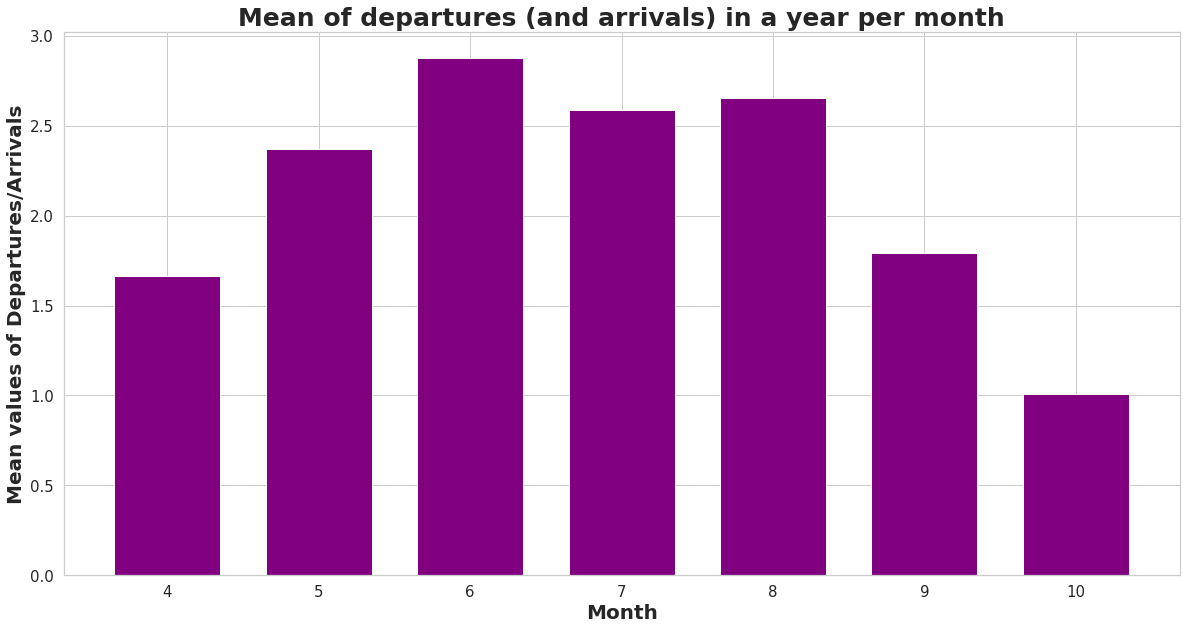

In [41]:
fig= plt.figure(figsize=(20,10))
# set width of bar
barWidth = 0.7

bars1 = grouped_by_month['departures']
# Set position of bar on X axis
r1 = np.arange(len(bars1))

# Make the plot
plt.bar(r1, bars1, color='purple', width=barWidth, edgecolor='white', label='var1')

# Add xticks on the middle of the group bars
plt.xlabel('Month', fontweight='bold', fontsize=20)
plt.ylabel('Mean values of Departures/Arrivals', fontweight='bold', fontsize=20)
plt.title(r'Mean of departures (and arrivals) in a year per month', fontsize=25, fontweight='bold')
plt.xticks([r for r in range(len(bars1))], grouped_by_month['month'], fontsize=15)
plt.yticks(fontsize=15)

In [42]:
# get mean departures and arrivals based on weekday in the whole year
grouped_by_weekday = data.groupby('weekday', as_index=False).mean()
grouped_by_weekday

,weekday,station_id,departures,arrivals,weather_rate,month
0,0,291.561507,2.213019,2.214312,6.957858,6.988503
1,1,291.582500,2.338518,2.335896,6.957749,7.020847
2,2,291.567396,2.430291,2.429492,7.063922,7.052346
3,3,291.567237,2.317268,2.315936,6.937490,7.084945
4,4,291.532020,2.143014,2.138148,6.530084,6.986960
5,5,291.620004,1.824544,1.820461,6.959975,7.019309
6,6,291.620004,1.665850,1.674020,6.980200,7.053003


(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ]),
 <a list of 7 Text major ticklabel objects>)

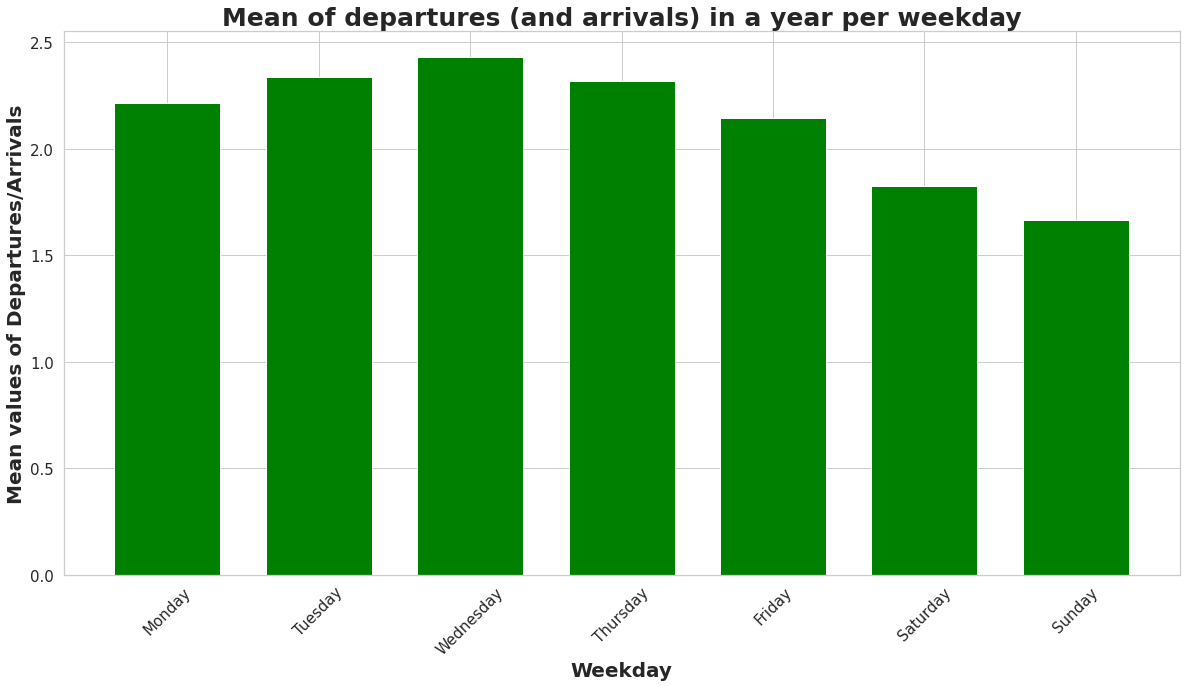

In [43]:
fig= plt.figure(figsize=(20,10))
# set width of bar
barWidth = 0.7

bars1 = grouped_by_weekday['departures']
# Set position of bar on X axis
r1 = np.arange(len(bars1))

# Make the plot
plt.bar(r1, bars1, color='green', width=barWidth, edgecolor='white', label='var1')

# Add xticks on the middle of the group bars
plt.xlabel('Weekday', fontweight='bold', fontsize=20)
plt.ylabel('Mean values of Departures/Arrivals', fontweight='bold', fontsize=20)
plt.title(r'Mean of departures (and arrivals) in a year per weekday', fontsize=25, fontweight='bold')
plt.xticks([r for r in range(len(bars1))], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], fontsize=15, rotation=45)
plt.yticks(fontsize=15)